In [1]:
# Celda 1: Importar librerías y módulos
import os
import numpy as np
import lcp.data_loader as dl
import lcp.processing as proc
import lcp.pathfinder as pf
import lcp.utils as utils

In [2]:
# ==============================================================================
# --- PARÁMETROS CONFIGURABLES POR EL USUARIO ---
# ==============================================================================
# Celda 2: Configuración del análisis
import os
from datetime import datetime

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'data')

# Crear una carpeta de sesión única para cada ejecución
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_DIR = os.path.join(BASE_DIR, 'output', f'session_{timestamp}')

# --- Rutas a los datos de entrada (ACTUALIZADAS) ---
COST_RASTER_PATH = os.path.join(DATA_DIR, 'cost.tif')
ALL_POINTS_SHAPEFILE = os.path.join(DATA_DIR, 'points.shp')
MASK_SHAPEFILE_PATH = os.path.join(DATA_DIR, 'area-mask.shp') # Puede ser None si no se usa

# --- Parámetros de cálculo (ACTUALIZADOS) ---
ORIGIN_POINT_ID = 5
ID_FIELD_NAME = 'id'
DOWNSAMPLING_FACTORS = [32, 20, 10]
CORRIDOR_BUFFER_PIXELS = 150
HEURISTIC_WEIGHT = 1.0

print(f"Configuración lista. Los resultados se guardarán en: {OUTPUT_DIR}")
print(f"Usando raster de costo: {os.path.basename(COST_RASTER_PATH)}")
print(f"Usando puntos de: {os.path.basename(ALL_POINTS_SHAPEFILE)}")
print(f"Punto de origen ID: {ORIGIN_POINT_ID}")

Configuración lista. Los resultados se guardarán en: G:\LCP\output\session_20250916_235600
Usando raster de costo: cost.tif
Usando puntos de: points.shp
Punto de origen ID: 5


In [3]:
# ==============================================================================
# --- EJECUCIÓN DEL ANÁLISIS ---
# ==============================================================================
os.makedirs(OUTPUT_DIR, exist_ok=True)

try:
    # 1. Cargar todos los datos de entrada
    all_points, points_crs = dl.load_points_as_dict(ALL_POINTS_SHAPEFILE, ID_FIELD_NAME)
    
    with dl.load_raster(COST_RASTER_PATH) as src:
        print("Cargando superficie de costo a memoria...")
        cost_data_high_res = src.read(1)
        
        # 2. Preparar la máscara de búsqueda principal
        if MASK_SHAPEFILE_PATH and os.path.exists(MASK_SHAPEFILE_PATH):
            main_search_mask = proc.create_mask_from_vector(MASK_SHAPEFILE_PATH, src)
        else:
            print("No se proporcionó máscara de polígono; se buscará en todo el raster.")
            main_search_mask = np.ones_like(cost_data_high_res, dtype=bool)

        # 3. Preparar el punto de origen
        origin_coords = all_points.get(ORIGIN_POINT_ID)
        if not origin_coords:
            raise ValueError(f"El ID de origen '{ORIGIN_POINT_ID}' no se encontró en el archivo de puntos.")
        
        start_pixel_hr = proc.world_to_pixel(src.transform, origin_coords[0], origin_coords[1])
        print(f"\nAnálisis desde el punto ID {ORIGIN_POINT_ID} (Píxel de alta res: {start_pixel_hr})")

        # 4. Bucle principal para calcular rutas a todos los destinos
        for dest_id, dest_coords in all_points.items():
            if dest_id == ORIGIN_POINT_ID:
                continue

            print(f"\n" + "="*50)
            print(f"--- Calculando ruta: {ORIGIN_POINT_ID} -> {dest_id} ---")
            print("="*50)
            end_pixel_hr = proc.world_to_pixel(src.transform, dest_coords[0], dest_coords[1])
            
            # FASE 1: Búsqueda a baja resolución con múltiples intentos
            path_found_lr, path_pixels_lr, successful_factor, trans_low = False, None, None, None
            print("-> FASE 1: Buscando en baja resolución...")
            for factor in DOWNSAMPLING_FACTORS:
                print(f"  Intentando con factor de remuestreo {factor}x...")
                cost_lr, trans_lr, dx_lr, dy_lr = proc.create_low_res_data(src, factor)
                mask_lr = main_search_mask[::factor, ::factor]
                start_lr = (start_pixel_hr[0] // factor, start_pixel_hr[1] // factor)
                end_lr = (end_pixel_hr[0] // factor, end_pixel_hr[1] // factor)
                
                found, came_from_lr = pf.a_star_search(cost_lr, src.nodata, start_lr, end_lr, dx_lr, abs(dy_lr), HEURISTIC_WEIGHT, mask_lr)
                
                if found:
                    print(f"  Éxito con factor {factor}.")
                    path_found_lr, successful_factor, trans_low = True, factor, trans_lr
                    path_pixels_lr = pf.reconstruct_path(came_from_lr, start_lr, end_lr)
                    break
                else:
                    print(f"  Falló con factor {factor}.")
            
            # FASE 2: Búsqueda a alta resolución
            print("\n-> FASE 2: Buscando en alta resolución...")
            path_found_hr, came_from_hr = False, None

            if path_found_lr and path_pixels_lr is not None:
                print("  Creando corredor a partir de la ruta de baja resolución...")
                corridor_mask = proc.create_search_corridor(path_pixels_lr, cost_data_high_res.shape, successful_factor, CORRIDOR_BUFFER_PIXELS)
                final_search_mask = np.logical_and(corridor_mask, main_search_mask)
                path_found_hr, came_from_hr = pf.a_star_search(cost_data_high_res, src.nodata, start_pixel_hr, end_pixel_hr, src.res[0], abs(src.res[1]), HEURISTIC_WEIGHT, final_search_mask)

            # PLAN B: Si la búsqueda en corredor falló
            if not path_found_hr:
                print("  Búsqueda en corredor fallida o no realizada. Iniciando PLAN B: búsqueda en toda la máscara.")
                path_found_hr, came_from_hr = pf.a_star_search(cost_data_high_res, src.nodata, start_pixel_hr, end_pixel_hr, src.res[0], abs(src.res[1]), HEURISTIC_WEIGHT, main_search_mask)

            # 5. Guardar los resultados de la iteración
            if path_found_hr:
                print(f"  ÉXITO FINAL: Se encontró la ruta para {ORIGIN_POINT_ID} -> {dest_id}.")
                path_pixels_hr = pf.reconstruct_path(came_from_hr, start_pixel_hr, end_pixel_hr)
                
                if path_pixels_lr is not None:
                    p1_path = os.path.join(OUTPUT_DIR, f"ruta_fase1_{ORIGIN_POINT_ID}_a_{dest_id}.shp")
                    utils.save_path_to_shapefile(path_pixels_lr, trans_low, src.crs, p1_path)
                
                final_path_shp = os.path.join(OUTPUT_DIR, f"ruta_final_{ORIGIN_POINT_ID}_a_{dest_id}.shp")
                utils.save_path_to_shapefile(path_pixels_hr, src.transform, src.crs, final_path_shp)
            else:
                print(f"  ERROR CRÍTICO: No se pudo encontrar ninguna ruta para {ORIGIN_POINT_ID} -> {dest_id}.")

except Exception as e:
    print(f"\nOcurrió un error fatal en la ejecución: {e}")
    import traceback
    traceback.print_exc()

finally:
    print("\n" + "="*50)
    print("--- ANÁLISIS COMPLETADO ---")
    print("="*50)

Cargando puntos desde: G:\LCP\data\points.shp
Se cargaron 14 puntos.
Cargando raster desde: G:\LCP\data\cost.tif
Raster cargado exitosamente.
Cargando superficie de costo a memoria...
Creando máscara booleana desde el polígono...
Máscara creada.

Análisis desde el punto ID 5 (Píxel de alta res: (105, 929))

--- Calculando ruta: 5 -> 1 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Falló con factor 32.
  Intentando con factor de remuestreo 20x...
  Éxito con factor 20.

-> FASE 2: Buscando en alta resolución...
  Creando corredor a partir de la ruta de baja resolución...
  ÉXITO FINAL: Se encontró la ruta para 5 -> 1.
Ruta guardada exitosamente en: ruta_fase1_5_a_1.shp
Ruta guardada exitosamente en: ruta_final_5_a_1.shp

--- Calculando ruta: 5 -> 2 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Falló con factor 32.
  Intentando con factor de remuestreo 20x...
  Éxito con factor 20.

-> FASE 2: Bu

Iniciando la visualización de resultados...


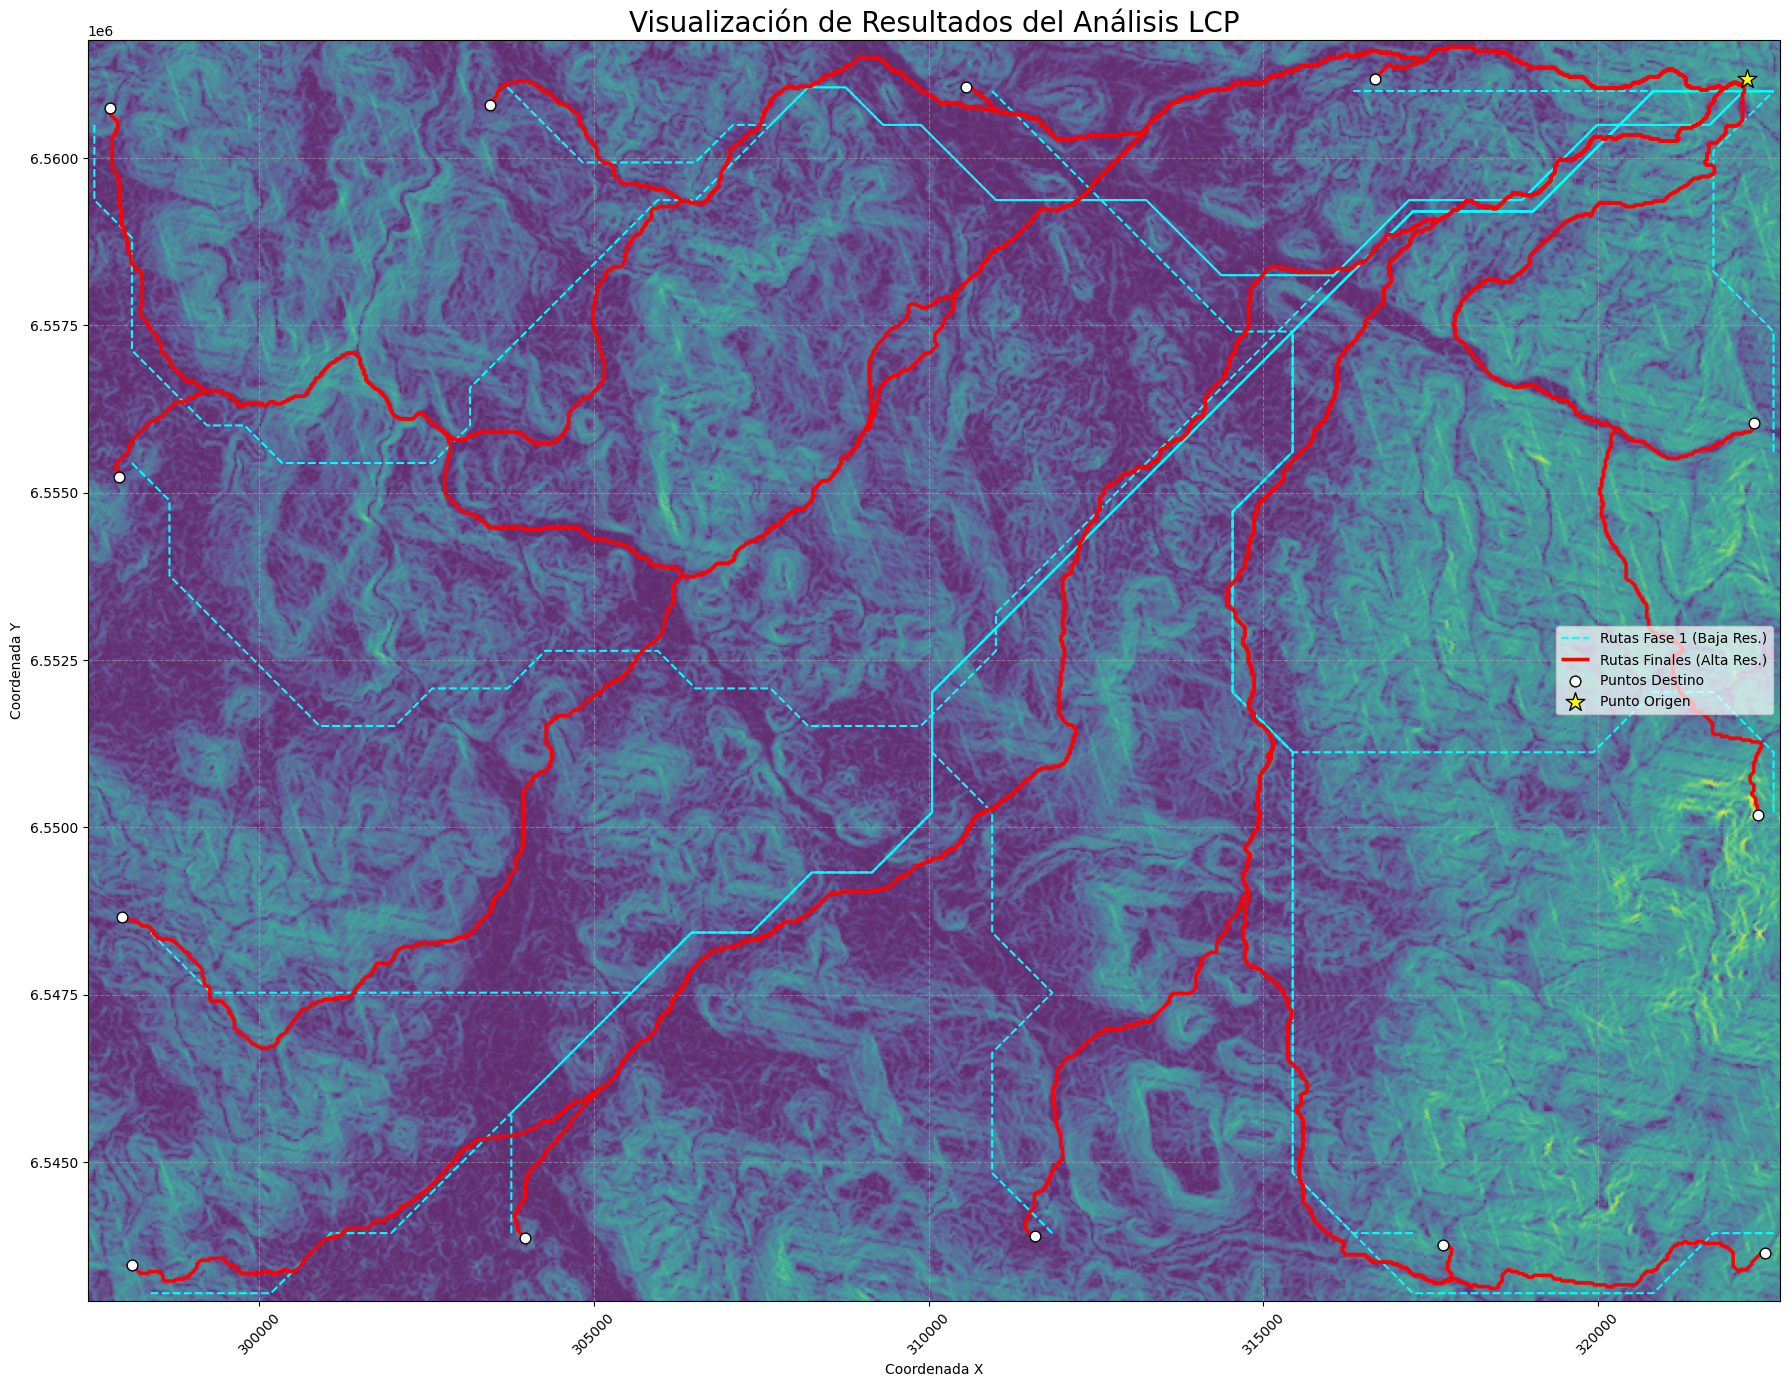

In [4]:
# ==============================================================================
# --- CELDA 4: VISUALIZACIÓN DE RESULTADOS ---
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import geopandas as gpd
import pandas as pd
import rasterio
import rasterio.plot
from rasterio.windows import from_bounds
import glob

print("Iniciando la visualización de resultados...")

try:
    # --- 1. Encontrar y cargar las rutas generadas ---
    # Usar glob para encontrar todos los shapefiles de rutas en la carpeta de la sesión
    phase1_route_files = glob.glob(os.path.join(OUTPUT_DIR, 'ruta_fase1_*.shp'))
    final_route_files = glob.glob(os.path.join(OUTPUT_DIR, 'ruta_final_*.shp'))

    if not final_route_files:
        print("No se encontraron archivos de rutas finales para visualizar. Asegúrate de que el análisis se haya ejecutado correctamente.")
    else:
        # Cargar todos los shapefiles de rutas en GeoDataFrames
        list_of_phase1_gdfs = [gpd.read_file(f) for f in phase1_route_files]
        list_of_final_gdfs = [gpd.read_file(f) for f in final_route_files]
        
        phase1_routes_gdf = pd.concat(list_of_phase1_gdfs, ignore_index=True) if list_of_phase1_gdfs else None
        final_routes_gdf = pd.concat(list_of_final_gdfs, ignore_index=True)

        # --- 2. Determinar la extensión total de las rutas con un margen ---
        # Unir todas las rutas para obtener una única extensión
        all_routes_gdf = pd.concat([phase1_routes_gdf, final_routes_gdf], ignore_index=True)
        
        # Obtener los límites (bounds) y añadir un margen de 100 unidades (metros, grados, etc.)
        minx, miny, maxx, maxy = all_routes_gdf.total_bounds
        margin = 100
        buffered_bounds = (minx - margin, miny - margin, maxx + margin, maxy + margin)
        
        # --- 3. Cargar la porción correspondiente del raster de costo ---
        with rasterio.open(COST_RASTER_PATH) as src:
            # Calcular la ventana de píxeles a partir de la extensión con margen
            window = from_bounds(*buffered_bounds, transform=src.transform)
            # Leer solo esa ventana del raster
            raster_data = src.read(1, window=window)
            # Obtener la transformación espacial para esta ventana específica
            window_transform = src.window_transform(window)

        # --- 4. Cargar los puntos originales ---
        points_gdf = gpd.read_file(ALL_POINTS_SHAPEFILE)

        # --- 5. Crear el mapa ---
        fig, ax = plt.subplots(figsize=(18, 18))
        ax.set_facecolor('gainsboro') # Color de fondo para áreas sin datos

        # Dibujar el raster de costo
        rasterio.plot.show(
            raster_data,
            transform=window_transform,
            ax=ax,
            cmap='viridis',
            norm=LogNorm(),  # LogNorm es ideal para visualizar costos con grandes variaciones
            alpha=0.8,
            zorder=1
        )
        
        # Dibujar las rutas de Fase 1 (si existen)
        if phase1_routes_gdf is not None:
            phase1_routes_gdf.plot(
                ax=ax,
                edgecolor='cyan',
                linewidth=1.5,
                linestyle='--',
                label='Rutas Fase 1 (Baja Res.)',
                zorder=3
            )

        # Dibujar las rutas finales
        final_routes_gdf.plot(
            ax=ax,
            edgecolor='red',
            linewidth=2.5,
            label='Rutas Finales (Alta Res.)',
            zorder=4
        )

        # Dibujar los puntos de destino
        points_gdf[points_gdf[ID_FIELD_NAME] != ORIGIN_POINT_ID].plot(
            ax=ax,
            color='white',
            markersize=60,
            ec='black',
            label='Puntos Destino',
            zorder=5
        )

        # Dibujar el punto de origen (encima de todo)
        points_gdf[points_gdf[ID_FIELD_NAME] == ORIGIN_POINT_ID].plot(
            ax=ax,
            color='yellow',
            markersize=200,
            ec='black',
            marker='*',
            label='Punto Origen',
            zorder=6
        )

        # Configuración final del mapa
        ax.set_title('Visualización de Resultados del Análisis LCP', fontsize=20)
        ax.set_xlabel("Coordenada X")
        ax.set_ylabel("Coordenada Y")
        ax.legend(loc='best', frameon=True, facecolor='white', framealpha=0.7)
        ax.tick_params(axis='x', rotation=45)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Ocurrió un error durante la visualización: {e}")
    import traceback
    traceback.print_exc()